<a href="https://colab.research.google.com/github/folaAj/jhu_nlp_class/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [1]:
!pip install datasets
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 212 kB 53.7 MB/s 
     |████████████████████████████████| 115 kB 66.4 MB/s 
     |████████████████████████████████| 182 kB 47.9 MB/s 
     |████████████████████████████████| 127 kB 66.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 46.8 MB/s 


In [3]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 497.9 MB 2.6 kB/s 
     |████████████████████████████████| 462 kB 49.2 MB/s 
     |████████████████████████████████| 1.4 MB 60.2 MB/s 
     |████████████████████████████████| 5.8 MB 38.9 MB/s 


In [4]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
     |████████████████████████████████| 238 kB 72.2 MB/s 
     |████████████████████████████████| 118 kB 68.1 MB/s 
     |████████████████████████████████| 352 kB 49.0 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.3 MB 46.6 MB/s 


In [60]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import  matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW
from official.nlp import optimization

import unicodedata

from datasets import load_dataset
from transformers import AutoTokenizer

tf.get_logger().setLevel('ERROR')

# Read dataset

I make use of the hugging face [rotten tomatoes dataset](https://huggingface.co/datasets/rotten_tomatoes).

In [6]:
dataset = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [9]:
from tokenizers import normalizers
from tokenizers.normalizers import NFKD, StripAccents 
normalizer = normalizers.Sequence([NFKD(), StripAccents()])

# Setup

Configure the distributed training strategy.

In [10]:
USE_TPU = False

In [11]:
def get_tpu_strategy():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy

In [12]:
if USE_TPU:
  strategy = get_tpu_strategy()
else:
  strategy = tf.distribute.MirroredStrategy()

Set up the batch size and the utility functions

In [66]:
strategy.num_replicas_in_sync

1

In [79]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [80]:
def normalize(x):
  """Normalizes the sentiment text.

  Args:
    x: The sentiment text.
  
  Returns:
    The normalized text.
  """
  x['text'] = unicodedata.normalize('NFKD', x['text']).encode('ascii', 'ignore')
  return x


train = dataset['train'].map(normalize).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(lambda x: (x['text'], x['label']))
val = dataset['validation'].map(normalize).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(lambda x: (x['text'], x['label']))
test = dataset['test'].map(normalize).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(lambda x: (x['text'], x['label']))

In [81]:
def build_classifier_model(should_finetune):
  """Builds a BERT based sentiment analysis classifier.
  Args:
    should_finetune: whether to finetune BERT or not"""
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
  tfhub_handle_preprocess =  'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=should_finetune, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [86]:
def train_model(*, model, learning_rate, epochs, train_data, validation_data):
  with strategy.scope():
    metrics = tf.metrics.BinaryAccuracy()
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = model.fit(x=train_data, validation_data=validation_data, epochs=epochs, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
  return history

In [87]:
def plot_learning_curves(history):
  fig, ax = plt.subplots(2)
  # Plot accuracy
  ax[0].plot(history.history['binary_accuracy'])
  ax[0].plot(history.history['val_binary_accuracy'])
  ax[0].set_ylabel('accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'validation'], loc='upper left')
  # Plot loss
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'validation'], loc='upper left')
  plt.show()

# Establish A Baseline

For my baseline I use a pretrained BERT model for feature extraction and try to use a neural network to predict if the sentiment is positive or negative.

In [88]:
with strategy.scope():
  baseline = build_classifier_model(should_finetune=False)

In [89]:
history = train_model(model = baseline, learning_rate=1e-05, epochs=10, train_data=train, validation_data=val)

Epoch 1/10
267/267 [==============================] - 45s 148ms/step - loss: 0.7531 - binary_accuracy: 0.5147 - val_loss: 0.6927 - val_binary_accuracy: 0.5084
Epoch 2/10
267/267 [==============================] - 34s 128ms/step - loss: 0.7026 - binary_accuracy: 0.5367 - val_loss: 0.6748 - val_binary_accuracy: 0.5535
Epoch 3/10
267/267 [==============================] - 33s 123ms/step - loss: 0.6923 - binary_accuracy: 0.5563 - val_loss: 0.6666 - val_binary_accuracy: 0.5657
Epoch 4/10
267/267 [==============================] - 36s 136ms/step - loss: 0.6794 - binary_accuracy: 0.5736 - val_loss: 0.6605 - val_binary_accuracy: 0.5779
Epoch 5/10
267/267 [==============================] - 34s 128ms/step - loss: 0.6800 - binary_accuracy: 0.5626 - val_loss: 0.6556 - val_binary_accuracy: 0.5760
Epoch 6/10
267/267 [==============================] - 33s 123ms/step - loss: 0.6720 - binary_accuracy: 0.5787 - val_loss: 0.6518 - val_binary_accuracy: 0.5797
Epoch 7/10
267/267 [==========================

In [90]:
baseline.evaluate(test)

34/34 [==============================] - 4s 106ms/step - loss: 0.6430 - binary_accuracy: 0.5976


[0.6430494785308838, 0.5975610017776489]

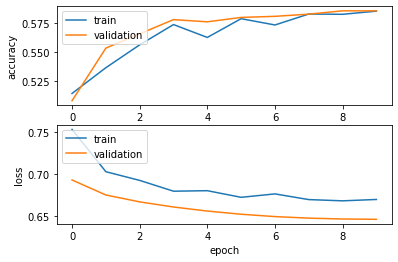

In [91]:
plot_learning_curves(history)

# Finetune  a BERT Model For Sentiment Analysis on Rotten Tomaotoes Dataset.

In [92]:
with strategy.scope():
  bert_finetuned_model = build_classifier_model(should_finetune=True)

In [93]:
finetuned_history = train_model(model = bert_finetuned_model, learning_rate=1e-05, epochs=10, train_data=train, validation_data=val)

Epoch 1/10
267/267 [==============================] - 72s 239ms/step - loss: 0.6073 - binary_accuracy: 0.6521 - val_loss: 0.4573 - val_binary_accuracy: 0.7636
Epoch 2/10
267/267 [==============================] - 62s 233ms/step - loss: 0.4465 - binary_accuracy: 0.7877 - val_loss: 0.4315 - val_binary_accuracy: 0.8068
Epoch 3/10
267/267 [==============================] - 63s 238ms/step - loss: 0.3243 - binary_accuracy: 0.8589 - val_loss: 0.4556 - val_binary_accuracy: 0.7983


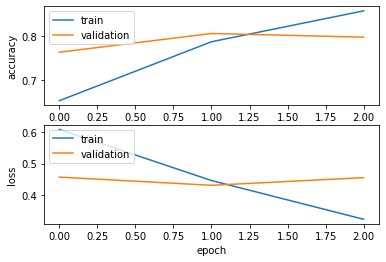

In [94]:
plot_learning_curves(finetuned_history)

In [95]:
bert_finetuned_model.evaluate(test)

34/34 [==============================] - 4s 104ms/step - loss: 0.4745 - binary_accuracy: 0.7983


[0.474526047706604, 0.7983114719390869]

# TODO: Include nltk sentiwordnet scores to the model to see if that feature helps.

https://srish6.medium.com/sentiment-analysis-using-the-sentiwordnet-lexicon-1a3d8d856a10